### Helpers

In [1]:
# %load_ext autoreload
# %autoreload 2

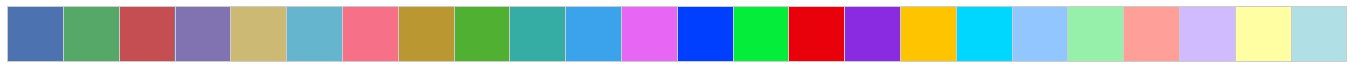

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
)
from pipeline import (
    split_classes, count_classes, sample,
    cross_validate, fit_predict_save, fit_save_model
)
from transformers.pca import pca_fit, pca_transform
from transformers.cosine import add_coses, to_degrees
from transformers.momentum import add_is_muon, add_is_muon_tight, add_probability_hit_detector
from transformers.err import add_mse, add_normed_err, err_cols

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

In [ ]:
%%time
convert_train()

Stored: 0.2M
Stored: 0.4M
Stored: 0.6M
Stored: 0.8M


In [153]:
%%time
test, test_foi = read_pub_test(SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS, foi_expanded=False)

Wall time: 16.3 s


In [150]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726095 entries, 0 to 726094
Empty DataFrame

In [ ]:
for i in range(len(test.index)):
    t = test.iloc[i, :][foi_ts_cols[0]]
    if np.any(np.isnan(t)):
        print(i, t)

In [13]:
xx = pd.DataFrame(index=[10, 20, 30])
xx.loc[:, 'a'] = [1., 2., 3.]
xx.loc[:, 'c'] = [1, 2, 3]

xx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 10 to 30
Data columns (total 2 columns):
a    3 non-null float64
c    3 non-null int64
dtypes: float64(1), int64(1)
memory usage: 72.0 bytes


In [17]:
xx = np.array([
    np.array([1, 2,]),
    np.array([3, 4, 5])
])
xx

array([1, 2, 3, 4, 5])

In [145]:
xx, xy = DatasetReader.read_dataset(meta_pub_test, SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS, nrows=1)

In [146]:
np.sum(xx[hit_stats_cols[0]]), len(xy.index)

(6, 6)

In [144]:
from itertools import repeat
import os.path
import numpy as np
import pandas as pd
from common import (
    SIMPLE_FEATURE_COLS, ARR_FEATURE_COLS, ALL_TRAIN_COLS,
    xyz_cols, dxyz_cols, t_cols,
    foi_ts_cols, unused_train_cols, train_cols, hit_stats_cols, ncl_cols, hit_type_cols
)

class DatasetMetaData:
    def __init__(self, origin_csv_filenames, chunk_filenames_pattern, origin_col_set):
        self.origin_csv_filenames = origin_csv_filenames
        self.chunk_filenames_pattern = chunk_filenames_pattern
        self.origin_col_set = origin_col_set
        self.is_test = 'test_' in chunk_filenames_pattern

meta_train = DatasetMetaData(
    origin_csv_filenames=['data/train_part_1_v2.csv.gz', 'data/train_part_2_v2.csv.gz'],
    chunk_filenames_pattern='data/train_{label}_{group}_{ind:03d}.pkl',
    origin_col_set=SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS + ALL_TRAIN_COLS
)
meta_pub_test = DatasetMetaData(
    origin_csv_filenames=['data/test_public_v2.csv.gz'],
    chunk_filenames_pattern='data/test_pub_{group}_{ind:03d}.pkl',
    origin_col_set=SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS
)
meta_pvt_test = DatasetMetaData(
    origin_csv_filenames=[],
    chunk_filenames_pattern='data/test_pvt_{group}_{ind:03d}.pkl',
    origin_col_set=SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS
)

col_groups = list(zip(['sf', 'af', 'tr'], [SIMPLE_FEATURE_COLS, ARR_FEATURE_COLS, ALL_TRAIN_COLS]))
label_prefixes = ['L0', 'L1']


class CsvDataReader:
    int_dtype = np.int32
    float_dtype = np.float32
    
    def __init__(self):
        self.na_values = ['-9999.0', '255']
    
    @staticmethod
    def get_read_stream(filenames, usecols, chunk_size=25000):
        return CsvDataReader()._get_read_stream(filenames, usecols, chunk_size)
    
    def _get_read_stream(self, filenames, usecols, chunk_size):
        if 'id' not in usecols:
            usecols += ['id']
            
        for filename in filenames:
            data_generator = pd.read_csv(
                filename, usecols=usecols, chunksize=chunk_size, index_col='id', #nrows=400000,
                na_values=self._get_na_values_dict(), keep_default_na=False,
                converters=self._get_converters(), dtype=self._get_types()
            )
            for data in data_generator:
                
                yield data

    def _get_na_values_dict(self):
        float_cols = [(col, '-9999.0') for col in xyz_cols + dxyz_cols]
        int_cols = [(col, '255') for col in t_cols]
        return {k:v for k, v in float_cols+int_cols}

    def _get_converters(self):
        def parse_float_array(line):
            arr = np.fromstring(line[1:-1], sep=" ", dtype=self.float_dtype)
            return arr

        converters = dict(zip(ARR_FEATURE_COLS, repeat(parse_float_array)))
        return converters
    
    def _get_types(self):
        types = dict(zip(SIMPLE_FEATURE_COLS + ALL_TRAIN_COLS, repeat(self.float_dtype)))
        for col in unused_train_cols[:1] + train_cols[:1] + hit_stats_cols + ncl_cols + hit_type_cols:
            types[col] = self.int_dtype
        types['id'] = self.int_dtype
        return types


class DataBuffer:
    def __init__(self):
        self._frames = []
    
    def append(self, frame):
        self._frames.append(frame)
    
    def cut(self, nrows):
        nrows = min(nrows, self.nrows)
        merged = self._merge_frames()
        head = merged.iloc[:nrows, :]
        tail = merged.iloc[nrows:, :]
        
        self._frames = [tail]
        return head, nrows
    
    def _merge_frames(self):
        if len(self._frames) > 1:
            merged = pd.concat(self._frames, axis=0, ignore_index=False)
            self._frames = [merged]
        return self._frames[0]
    
    @property
    def nrows(self):
        return sum([len(frame.index) for frame in self._frames])
    
    @property
    def is_empty(self):
        return self.nrows == 0


class DataTank:
    def __init__(self, max_volume, callback_on_full, early_stop=False):
        self._max_volume = max_volume
        self._buffer = DataBuffer()
        self._on_full = callback_on_full
        self._early_stop = early_stop
    
    def add(self, frame):
        if frame is None:
            return 0
        
        self._buffer.append(frame)
        flushed = 0
        while self._is_full():
            flushed += self.flush()
            if self._early_stop:
                break
        return flushed
        
    def flush(self):
        if self._buffer.is_empty:
            return 0
        flushed_data, flushed_vol = self._buffer.cut(self._max_volume)
        self._on_full(flushed_data)
        return flushed_vol
    
    def _is_full(self):
        return self._buffer.nrows >= self._max_volume


class TestDatasetHelper:
    def __init__(self, filename_pattern):
        self._filename_pattern = filename_pattern

    def filter_frame(self, frame):
        return frame
        
    def get_col_groups(self):
        return col_groups[:-1]

    def generate_chunk_filename(self, group_key, chunk_ind):
        return self._filename_pattern.format(group=group_key, ind=chunk_ind)


class TrainDatasetHelper:
    def __init__(self, filename_pattern, label, label_key):
        self._filename_pattern = filename_pattern
        self._label = label
        self._label_key = label_key

    def filter_frame(self, frame):
        return frame.loc[frame.label == self._label, :]

    def get_col_groups(self):
        return col_groups

    def generate_chunk_filename(self, group_key, chunk_ind):
        return self._filename_pattern.format(label=self._label_key, group=group_key, ind=chunk_ind)


class PickleDataWriter:
    def __init__(self, helper, chunk_size):
        self._helper = helper
        self._data_tank = DataTank(max_volume=chunk_size, callback_on_full=self._flush_chunk)
        self._chunk_index = 0
    
    def store(self, frame):
        filtered_frame = self._helper.filter_frame(frame)
        return self._data_tank.add(filtered_frame)
        
    def flush(self):
        return self._data_tank.flush()
    
    def _flush_chunk(self, chunk):
        self._store_chunk(chunk, self._chunk_index)
        self._chunk_index += 1
        
    def _store_chunk(self, chunk, chunk_index):
        for group_key, col_group in self._helper.get_col_groups():
            filename = self._helper.generate_chunk_filename(group_key, chunk_index)
            chunk.loc[:, col_group].to_pickle(filename)
            
            if group_key == 'af':
                filename = self._helper.generate_chunk_filename('afexp', chunk_index)
                self._expand(chunk, col_group).to_pickle(filename)
                
    @staticmethod
    def _expand(data, cols):
        ids = np.repeat(data.index.values, data['FOI_hits_N'].values)
        result = pd.DataFrame(data=ids, columns=['id'])
        for col in cols:
             result.loc[:, col] = np.hstack(data.loc[:, col])
        return result
    

class PickleDataReader:
    def __init__(self, helper, foi_expanded):
        self._helper = helper
        self._result = None
        self._foi_result = None
        self._foi_expanded = foi_expanded
        
    def read(self, nrows, cols):
        data_tank = DataTank(nrows, self._set_read_result, early_stop=True)
        foi_data_tank = DataTank(100000000, self._set_foi_read_result)
        
        for frame, foi_frame in self._read_chunks(cols):
            foi_data_tank.add(foi_frame)
            if data_tank.add(frame) > 0:
                foi_data_tank.flush()
                return self._result, self._foi_result

        data_tank.flush()
        foi_data_tank.flush()
        return self._result, self._foi_result
        
    def _read_chunks(self, cols):
        chunk_index = 0
        while True:
            frame, foi_frame = self._read_chunk(chunk_index, cols)
            if frame is None:
                break
            
            yield frame, foi_frame
            chunk_index += 1
            
    def _set_read_result(self, data):
        self._result = data
        
    def _set_foi_read_result(self, data):
        self._foi_result = data
    
    def _read_chunk(self, chunk_index, cols):
        chunk_parts = []
        foi_dataframe = None        
        for group_key, col_group in self._helper.get_col_groups():
            cols_ = self._intersect_cols(cols, set(col_group))
            if not cols_:
                continue
            
            filename = self._helper.generate_chunk_filename(group_key, chunk_index)
            if not os.path.exists(filename):
                return None, None
            
            if group_key == 'af' and self._foi_expanded:
                filename = self._helper.generate_chunk_filename('afexp', chunk_index)
                foi_dataframe = pd.read_pickle(filename).loc[:, ['id'] + cols_]
                continue
            
            chunk_part = pd.read_pickle(filename).loc[:, cols_]
            chunk_parts.append(chunk_part)
            
        dataframe = pd.concat(chunk_parts, axis=1, sort=False)
        return dataframe, foi_dataframe
    
    @staticmethod
    def _intersect_cols(cols, col_subset):
        return [col for col in cols if col in col_subset]


class DatasetConverter:
    def __init__(self):
        self._stored = 0
                
    @staticmethod
    def convert(data_set_meta: DatasetMetaData, chunk_size=50000):
        dataframes_stream = CsvDataReader.get_read_stream(data_set_meta.origin_csv_filenames, data_set_meta.origin_col_set)
        
        filename_pattern = data_set_meta.chunk_filenames_pattern
        if data_set_meta.is_test:
            writers = [PickleDataWriter(TestDatasetHelper(filename_pattern), chunk_size)]
        else: 
            writers = [PickleDataWriter(TrainDatasetHelper(filename_pattern, i, label_prefixes[i]), chunk_size) for i in range(2)]
            
        DatasetConverter()._store_chunkified(dataframes_stream, writers)
        
    def _store_chunkified(self, dataframes_stream, writers):
        for data in dataframes_stream:
            for writer in writers:
                self._print_stored(writer.store(data))

        for writer in writers:
            self._print_stored(writer.flush())
            
    def _print_stored(self, stored):
        if stored == 0:
            return
        self._stored += stored
        if self._stored % 200000 == 0:
            print('Stored: {0}M'.format(self._stored / 1000000.))


class DatasetReader:
    @staticmethod
    def read_dataset(data_set_meta: DatasetMetaData, cols, nrows=None, prop_0=.5, foi_expanded=True):
        nrows = nrows if nrows is not None else 100000000
        filename_pattern = data_set_meta.chunk_filenames_pattern
        if data_set_meta.is_test:
            readers = [PickleDataReader(TestDatasetHelper(filename_pattern), foi_expanded=foi_expanded)]
            proportions = [nrows]
        else: 
            readers = [PickleDataReader(TrainDatasetHelper(filename_pattern, i, label_prefixes[i]), foi_expanded=foi_expanded) for i in range(2)]
            nrows0 = int(nrows * prop_0)
            proportions = [nrows0, nrows - nrows0]
            
        return DatasetReader()._read_dataset(readers, cols, proportions)
            
    def _read_dataset(self, readers, cols, proportions):
        data_parts = []
        foi_data_parts = []
        delta = 0
        col_delta = hit_stats_cols[:1] if hit_stats_cols[0] not in cols else []
        for reader, nrows in zip(readers, proportions):
            data_part, foi_data_part = reader.read(nrows + delta, cols + col_delta)
            if col_delta:
                data_part = data_part.drop(col_delta, axis=1)
            data_parts.append(data_part)
            if foi_data_part is not None:
                foi_data_part = foi_data_part.loc[foi_data_part.id < nrows, :]
                foi_data_parts.append(foi_data_part)
            delta = nrows - len(data_part.index)
            
        data = pd.concat(data_parts, axis=0, ignore_index=False)
        foi_data = pd.concat(foi_data_parts, axis=0, ignore_index=False) if foi_data_parts else None
        return data, foi_data


def convert_train():
    DatasetConverter.convert(meta_train)

def convert_pub_test():
    DatasetConverter.convert(meta_pub_test)
    
def convert_pvt_test():
    DatasetConverter.convert(meta_pvt_test)
    
def read_train(cols, rows, foi_expanded=True):
    return DatasetReader.read_dataset(meta_train, cols + train_cols, rows, foi_expanded=foi_expanded)

def read_pub_test(cols, foi_expanded=True):
    return DatasetReader.read_dataset(meta_pub_test, cols, foi_expanded=foi_expanded)

def read_pvt_test(cols, foi_expanded=True):
    return DatasetReader.read_dataset(meta_pvt_test, cols, foi_expanded=foi_expanded)

### Reading

In [12]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols
global_feature_importance = None
train = read_train(used_cols, 1000000)
display(train.shape, count_classes(train))

(1000000, 63)

(421218, 578782)

Wall time: 3.07 s


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [4]:
dll_train = read_train(xy_cols + dx_cols + dy_cols + exy_cols, 10000000)

In [5]:
dll_train = add_mse(dll_train, [])

In [6]:
def create_pdfs(data):
    dts = [dt.loc[:, err_cols[0]] for dt in split_classes(data)]
    min_len = min(map(len, dts))
    nbins = int(round(np.sqrt(min_len) / np.pi))
    nbins = 230
    
    l, r = np.min(data[err_cols[0]]) - 1e-5, np.max(data[err_cols[0]]) + 1e-5
    k = 9
    m = (r - l) / k
    m = 20
    bins = np.concatenate((
        np.arange(l, 1, .02),
        np.arange(1, 3, .04),
        np.arange(3, 10, .1),
        np.arange(10, 16, .4),
        np.arange(16, 34, 1.),
        np.arange(34, 66, 2),
        np.arange(66, 120, 5.),
        np.linspace(120, r, 3),
    ))
    nbins = len(bins)
    print(nbins)
#     bins = np.concatenate((
#         np.linspace(l, m, (k-1) * nbins // k, endpoint=False), 
#         np.linspace(m, r, nbins // k)
#     ))
    pdfs = []
    
    for i in range(2):
        pdf, _ = np.histogram(dts[i], bins=bins)
        pdfs.append(pdf)
                       
    return pdfs, bins
                       
pdfs, bins = create_pdfs(dll_train)

233


In [122]:
pdfs

NameError: name 'pdfs' is not defined

In [17]:
def add_dll(data, features):
    def get_probs(pdf, x):
        indices = np.digitize(x, bins) - 1
        wbin = (bins[indices + 1] - bins[indices]) / (np.max(bins) - np.min(bins))
        prob = pdf[indices] / pdf.sum()
        return prob #* wbin

    def get_dll(x):
        probs = [get_probs(pdf, x) for pdf in pdfs]
        DLL = np.log(probs[1]) - np.log(probs[0])
        return DLL

    data[err_cols[1]] = get_dll(data.loc[:, err_cols[0]])
    features += err_cols[1:2]
    return data

df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.779999,0.772095,0.880412,0.822643,0.812830,0.708636,0.092701,0.0
std,0.007281,0.009568,0.010734,0.005255,0.014001,0.048772,0.007831,0.0
min,0.774445,0.761525,0.868462,0.818848,0.798002,0.652489,0.087179,0.0
25%,0.775878,0.768060,0.876001,0.819644,0.806334,0.692708,0.088220,0.0
50%,0.777311,0.774596,0.883540,0.820439,0.814666,0.732927,0.089260,0.0
75%,0.782777,0.777380,0.886387,0.824540,0.820245,0.736710,0.095462,0.0
max,0.788242,0.780165,0.889234,0.828641,0.825823,0.740492,0.101663,0.0


In [18]:
import numpy as np
from common import x_cols, y_cols, z_cols

da_cols = ['DAngle[%d]' % i for i in range(1, 4)]

def add_coses(data, features):
    def get_layer_coords(data, i):
        return data[[x_cols[i], y_cols[i], z_cols[i]]].values
  
    def dot(x, y):
        return np.sum(x * y, axis=1, dtype=np.float32)
    
    def norm(x):
        return np.sqrt(dot(x, x))

    def get_cosine_dist(L1, L2, L1_norm, L2_norm):
        cosines = dot(L1, L2) / L1_norm / L2_norm
        return np.clip(cosines, -1., 1.)
    
    layers = np.array([get_layer_coords(data, i) for i in range(4)])
    layers[1:] -= layers[:3]
    layers[0] = get_zero_point(data)
    
    for i in range(3):
        cur_layer = layers[i]
        next_layer = layers[i+1]
        nan_mask = np.isnan(next_layer[:, 0])
        next_layer[nan_mask, :] = cur_layer[nan_mask, :]
        
        cosines = get_cosine_dist(cur_layer, next_layer, norm(cur_layer), norm(next_layer))
        degrees = to_degrees(cosines)
        cosines[nan_mask] = np.NaN
        degrees[nan_mask] = np.NaN
        data[da_cols[i]] = degrees
        
    features += da_cols
    return data

def to_degrees(cosine):
    return np.arccos(cosine) / np.pi * 180.

def _to_degrees(cosines):
    angles = cosines.copy()
    isn_mask = ~np.isnan(cosines)
    angles[isn_mask] = np.arccos(cosines[isn_mask]) / np.pi * 180.
    return angles

def get_zero_point(data):
    layers = [data[[ex_cols[i], ey_cols[i], z_cols[i]]].values for i in range(2)]
    d = layers[1] - layers[0]
    return d
    
df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.772400,0.764811,0.874285,0.815872,0.804206,0.689943,0.097152,0.0
std,0.005951,0.007636,0.002642,0.003701,0.007953,0.084526,0.006686,0.0
min,0.767177,0.757412,0.872075,0.812922,0.796970,0.600755,0.090074,0.0
25%,0.769161,0.760885,0.872822,0.813796,0.799948,0.650480,0.094047,0.0
50%,0.771146,0.764357,0.873569,0.814671,0.802925,0.700206,0.098020,0.0
75%,0.775012,0.768511,0.875390,0.817348,0.807824,0.734537,0.100691,0.0
max,0.778878,0.772665,0.877211,0.820024,0.812722,0.768869,0.103361,0.0


In [19]:
err_x_cols = ['Err_X[%i]' % i for i in range(N_STATIONS)]
err_y_cols = ['Err_Y[%i]' % i for i in range(N_STATIONS)]
err_z_cols = ['Err_Z[%i]' % i for i in range(N_STATIONS)]
err_xy_cols = err_x_cols + err_y_cols
err_xyz_cols = err_xy_cols + err_z_cols
ez = np.array([15270., 16470., 17670., 18870.])

def add_errs(data, features):
    for err_col, e_col, col in zip (err_xy_cols, exy_cols, xy_cols):
        data.loc[:, err_col] = data[e_col].values - data[col].values
        
    for i in range(4):
        data.loc[:, err_z_cols[i]] = ez[i] - data[z_cols[i]].values
    
    features += err_xyz_cols
    
df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=1000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.767981,0.754840,0.899815,0.820640,0.796658,0.590769,0.200585,0.0
std,0.025779,0.029614,0.014865,0.015686,0.019841,0.358864,0.029793,0.0
min,0.738739,0.720648,0.882653,0.803612,0.775845,0.346106,0.166246,0.0
25%,0.758258,0.746100,0.895408,0.813711,0.787308,0.384785,0.191099,0.0
50%,0.777778,0.771552,0.908163,0.823810,0.798770,0.423464,0.215953,0.0
75%,0.782601,0.771937,0.908396,0.829154,0.807064,0.713100,0.217754,0.0
max,0.787425,0.772321,0.908629,0.834499,0.815358,1.002735,0.219556,0.0


In [20]:
def add_mse(data, features):
#     dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
    xy_vals = data.loc[:, xy_cols].values

    dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
    D = np.nanmean(dxy**2, axis=1)
    
    data.loc[:, err_cols[0]] = D
    features += [err_cols[0]]
    return data

In [47]:
%%time
def sample(data, nrows):
    return data.iloc[np.random.permutation(len(data.index))[:nrows], :]

Wall time: 0 ns


In [59]:
%%time
from sklearn.base import TransformerMixin

def filter_unimportant_features(features):
    if global_feature_importance is None:
        return features
    fscore = global_feature_importance
    return [col for col in features if col not in fscore.index or fscore.loc[col, 'score'] > 0.01]
#     return features

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        features = [] + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + xyz_cols
        features = filter_unimportant_features(features)
        self.origin_features = features.copy()

#         add_is_muon(data, features)
#         add_is_muon_tight(data, features)
#         add_probability_hit_detector(data, features)
        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
        add_dll(data, features)
        add_errs(data, features)
        
#         filter_data(data)
        if not features:
            raise('no features')
    
        features = filter_unimportant_features(features)
        self.new_features = features[len(self.origin_features):]
        self.features = self.origin_features + self.new_features
#         print(len(features))
        return data[features].values

df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=30000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.781600,0.774079,0.881269,0.824194,0.811250,0.734905,0.092396,0.0
std,0.006525,0.007069,0.002465,0.004571,0.009118,0.023829,0.005642,0.0
min,0.776400,0.769335,0.878464,0.820286,0.805473,0.707415,0.088129,0.0
25%,0.777939,0.770017,0.880358,0.821681,0.805994,0.727519,0.089198,0.0
50%,0.779478,0.770699,0.882252,0.823076,0.806516,0.747622,0.090268,0.0
75%,0.784200,0.776451,0.882672,0.826149,0.814138,0.748650,0.094530,0.0
max,0.788921,0.782204,0.883092,0.829221,0.821761,0.749678,0.098793,0.0


Wall time: 5.59 s


### Test theory

In [60]:
%%time
df_scores, feature_importance = cross_validate(train, n_estimators=120, n_splits=5, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,0.787160,0.780853,0.881545,0.828147,0.819279,0.748660,0.082433,0.0
std,0.001963,0.002090,0.002466,0.001535,0.002022,0.036916,0.001952,0.0
min,0.784500,0.778890,0.877697,0.825746,0.817059,0.714958,0.079617,0.0
25%,0.786050,0.779597,0.880695,0.827620,0.817730,0.725527,0.081694,0.0
50%,0.787161,0.779601,0.882424,0.828547,0.819175,0.737313,0.082687,0.0
75%,0.789000,0.782605,0.882853,0.829300,0.820341,0.756992,0.083289,0.0
max,0.789089,0.783573,0.884057,0.829523,0.822088,0.808510,0.084876,0.0


Wall time: 52.7 s


In [25]:
sum(global_feature_importance.score > .01)

26

In [24]:
display(global_feature_importance)

,score
ErrMSE,0.136038
PT,0.094272
NShared,0.052506
ncl[0],0.040573
DAngle[1],0.039379
DAngle[2],0.035800
P,0.033413
ncl[2],0.031026
NErr_X[3],0.029833
NErr_Y[3],0.027446


In [23]:
global_feature_importance = feature_importance.copy()

### Get result

In [62]:
test = read_pub_test(used_cols)

In [63]:
%%time
fit_predict_save(sample(train, 100000), test, "out/09_importance_001_100.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 24.8 s


In [107]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_120.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 6min 57s


In [108]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_200.csv", n_estimators=200, transformer_cls=DataTransformer)

Wall time: 11min 39s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [139]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [5]:
from transformers.cosine import da_cols
from transformers.err import err_cols, nerr_xy_cols

In [18]:
dt = read_train(SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS, 10000)

In [27]:
xx = np.hstack(dt.loc[:, foi_cols[0]].values)
xx.shape

(89534,)

In [94]:
def to_closest_cols(cols):
    return ['Cl_' + col for col in cols]

cl_xyz_cols = to_closest_cols(xyz_cols)
cl_t_cols = to_closest_cols(t_cols)
cl_dxyz_cols = to_closest_cols(dxyz_cols)
cl_cols = cl_xyz_cols + cl_t_cols + cl_dxyz_cols

# def fill_station()

def get_matched_hits(exy, foi_info):
    print(type(foi_info[foi_ts_cols[-1]]))
    result = np.empty(len(cl_cols), dtype=np.float32)
    for i in range(4):
        hits = (foi_info[foi_ts_cols[2]] == i)
        if hits.any():
            x_distances_2 = (exy[exy_cols[i]] - foi_info[foi_xyz_cols[i]][hits])**2
            y_distances_2 = (exy[exy_cols[i+4]] - foi_info[foi_xyz_cols[i+4]][hits])**2
            distances_2 = x_distances_2 + y_distances_2
            
            closest_hit = np.argmin(distances_2)
            return closest_hit
#             closest_x_per_station[station] = x_distances_2[closest_hit]
#             closest_y_per_station[station] = y_distances_2[closest_hit]
#             closest_T_per_station[station] = row["FOI_hits_T"][hits][closest_hit]
#             closest_z_per_station[station] = row["FOI_hits_Z"][hits][closest_hit]
#             closest_dx_per_station[station] = row["FOI_hits_DX"][hits][closest_hit]
#             closest_dy_per_station[station] = row["FOI_hits_DY"][hits][closest_hit]

for i in range(len(dt.index)):
    row = dt.iloc[i, :]
    get_matched_hits(row[exy_cols], row[foi_cols])
    break

<class 'str'>


AttributeError: 'bool' object has no attribute 'any'